In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
# using the SQLite Table to read data.
#con = sqlite3.connect('../input/database.sqlite')
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [3]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [9]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [10]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'own', 'too', 'through', 'further', 'to', 'd', 'not', 'itself', 'her', 'once', 'yours', 'wasn', 'because', 'why', 'on', 'only', "doesn't", "wouldn't", 'here', 'now', "weren't", 'just', 'under', "mustn't", 'for', "you'll", "you're", 'but', 'this', 'their', 'had', 'any', "don't", 'until', 'nor', 'll', "didn't", "isn't", 'ourselves', 'whom', 'don', 'wouldn', 'is', 'than', 'myself', "wasn't", 'be', 'it', "shouldn't", 'y', 'off', 's', "that'll", 'were', 'didn', 'have', "needn't", 'about', 'a', 'being', 'by', 'mightn', 'so', 'ours', 'my', 'haven', 'and', 'most', 'doesn', 'are', 'how', 'both', 'in', "aren't", 'during', 'shouldn', 'when', 'your', 'should', 'down', 'few', 'hadn', 'its', 'them', 'our', 'yourself', 'same', 'won', 'm', "hasn't", 'i', 'we', "it's", 'him', 'needn', 'again', 'yourselves', 'at', 'above', "should've", "you've", 'mustn', 'couldn', 'which', 'from', 'himself', 'some', 'they', 'you', 'between', 'hasn', 'he', 'having', 'there', 'as', 'who', 'herself', 'will', 'that', 'up',

In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [14]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review

In [15]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [16]:
# To get 2k +ve and 2k -ve reviews randomly.

data_pos = final[final["Score"] == "positive"].sample(n = 2000)
data_neg = final[final["Score"] == "negative"].sample(n = 2000)
final_4000 = pd.concat([data_pos, data_neg])

In [18]:
score_4000 = final_4000["Score"]

In [19]:
score_4000.shape

(4000,)

In [20]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_4000['CleanedText'].values)

In [21]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [22]:
final_counts.get_shape()

(4000, 9113)

In [23]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


In [24]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10 ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_4000['CleanedText'].values)

In [25]:
final_bigram_counts.get_shape()

(4000, 2468)

In [26]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

C:\Users\sande\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\sande\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(4000, 2468)

In [27]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [28]:
# convert sparse to dense as tsne takes dense vector
std_data = std_data.todense()

In [29]:
type(std_data)

numpy.matrixlib.defmatrix.matrix

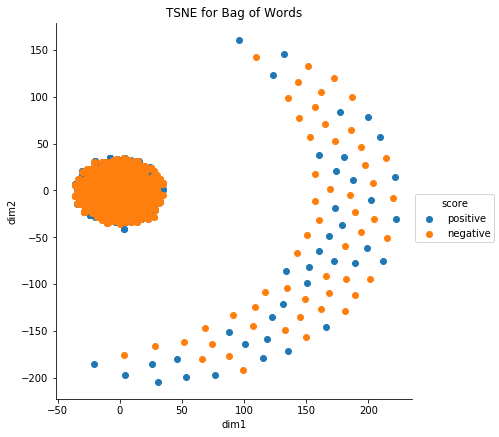

In [30]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

#  TF-idf

In [34]:
# Tf-Idf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
final_tf_idf = tf_idf_vect.fit_transform(final_4000['CleanedText'].values)

In [35]:
# Standardization 
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean = False)
std_data = std.fit_transform(final_tf_idf)

In [36]:
# Converting sparse matrix to dense because tnse takes dense vector
std_data = std_data.todense()

In [37]:
std_data.shape

(4000, 2468)

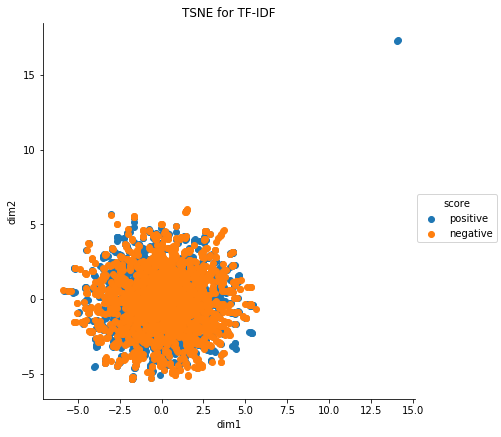

In [39]:
# tsne
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 50)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data = tsne_data, columns = ("dim1", "dim2", "score"))
sns.FacetGrid(tsne_df, hue = "score", size = 6).map(plt.scatter, "dim1", "dim2").add_legend()
plt.title("TSNE for TF-IDF")
plt.show()

In [40]:
features = tf_idf_vect.get_feature_names()
len(features)

2468

In [41]:
# covnert a row in saprsematrix to a numpy array
print(final_tf_idf[3,:].toarray()[0]) 

[0. 0. 0. ... 0. 0. 0.]


In [42]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)

In [43]:
# Using Google News Word2Vectors
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file which contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


#model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [45]:
import gensim
list_of_sent = []
for sent in final_4000['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [46]:
print(final_4000['Text'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

Our dog loves this toy and so does our vet. He can't believe how clean our dog's teeth are because of this toy.
*****************************************************************
['our', 'dog', 'loves', 'this', 'toy', 'and', 'so', 'does', 'our', 'vet', 'he', 'cant', 'believe', 'how', 'clean', 'our', 'dogs', 'teeth', 'are', 'because', 'of', 'this', 'toy']


In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

C:\Users\sande\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [49]:
w2v = w2v_model[w2v_model.wv.vocab]

C:\Users\sande\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [50]:
w2v.shape

(4059, 50)

In [51]:
words = list(w2v_model.wv.vocab)
print(len(words))

4059


In [52]:
w2v_model.wv.most_similar('tasty')

[('healthy', 0.9845033884048462),
 ('satisfying', 0.9825837016105652),
 ('fresh', 0.9779580235481262),
 ('delicious', 0.9778614044189453),
 ('crunchy', 0.9751331210136414),
 ('chewy', 0.9746720790863037),
 ('overly', 0.9712256193161011),
 ('soft', 0.9693647027015686),
 ('thick', 0.9671677947044373),
 ('tasting', 0.9670693278312683)]

In [53]:
w2v_model.wv.most_similar('like')

[('tastes', 0.865517795085907),
 ('but', 0.8645614385604858),
 ('taste', 0.8607438206672668),
 ('strong', 0.8546886444091797),
 ('really', 0.851535975933075),
 ('think', 0.8351844549179077),
 ('salty', 0.8314005732536316),
 ('bad', 0.8228658437728882),
 ('too', 0.8222863674163818),
 ('describe', 0.8205002546310425)]

# avg w2v

In [54]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

4000
50


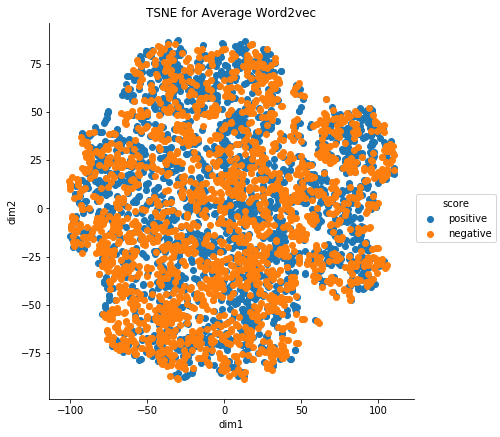

In [55]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 20, n_iter = 5000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

In [57]:
# To avoid warnings 
# http://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [58]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [60]:
# To know length of tfidf vector
len(tfidf_sent_vectors)

4000

In [61]:
np.isnan(tfidf_sent_vectors)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [62]:
# To replace nan with 0 and inf with large finite number

tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

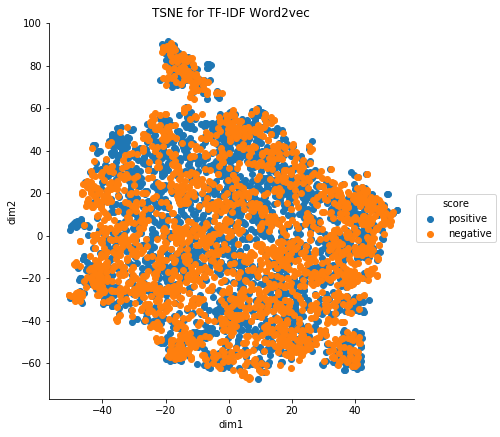

In [63]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, score_4000)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

# conclusions: